In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/converting-date/T_Loss.csv
/kaggle/input/converting-date/Temp.csv
/kaggle/input/converting-date/flow_out_1.csv
/kaggle/input/converting-date/ET.csv
/kaggle/input/obs-discharge/Tikarpara_Obs_Discharge_Formatted.csv
/kaggle/input/original-observed-values/daily_avg_precip.csv
/kaggle/input/original-observed-values/Temp_converted.csv
/kaggle/input/swat-output-1/ET_converted.csv
/kaggle/input/swat-output-1/flow_out_1_converted.csv
/kaggle/input/swat-output-1/Temp_converted.csv
/kaggle/input/swat-output-1/T_Loss_converted.csv
/kaggle/input/swat-output-1/obs_pred_trial_plot_prec.csv


Swat-Lstm

With updated data

In [ ]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Step 2: Load datasets and rename columns
temp_obs = pd.read_csv('/kaggle/input/original-observed-values/Temp_converted.csv', parse_dates=['Date'])
temp_obs.rename(columns={'Tikarpara_Calibration-rch-1-WTMPdegc': 'Temp_obs'}, inplace=True)

precip_obs = pd.read_csv('/kaggle/input/original-observed-values/daily_avg_precip.csv', parse_dates=['Date'])
precip_obs.rename(columns={'Avg_Precip_mm': 'Precip_obs'}, inplace=True)

obs_discharge = pd.read_csv('/kaggle/input/obs-discharge/Tikarpara_Obs_Discharge_Formatted.csv', parse_dates=['Date'])
obs_discharge.rename(columns={'Tikarpara_obs_discharge': 'Discharge_obs'}, inplace=True)

et_swat = pd.read_csv('/kaggle/input/swat-output-1/ET_converted.csv', parse_dates=['Date'])
et_swat.rename(columns={'Tikarpara_Calibration-rch-1-EVAPcms': 'ET_swat'}, inplace=True)

t_loss = pd.read_csv('/kaggle/input/swat-output-1/T_Loss_converted.csv', parse_dates=['Date'])
t_loss.rename(columns={'Tikarpara_Calibration-rch-1-TLOSScms': 'T_loss_swat'}, inplace=True)

flow_swat = pd.read_csv('/kaggle/input/swat-output-1/flow_out_1_converted.csv', parse_dates=['Date'])
flow_swat.rename(columns={'Tikarpara_Calibration-rch-1-FLOW_OUTcms': 'Flow_swat'}, inplace=True)

precip_swat = pd.read_csv('/kaggle/input/swat-output-1/obs_pred_trial_plot_prec.csv', parse_dates=['Date'])
precip_swat.rename(columns={'PRECIPmm': 'Precip_swat'}, inplace=True)

# Step 3: Merge all datasets
df = temp_obs.merge(precip_obs, on='Date')\
             .merge(obs_discharge, on='Date')\
             .merge(et_swat, on='Date')\
             .merge(t_loss, on='Date')\
             .merge(flow_swat, on='Date')\
             .merge(precip_swat[['Date', 'Precip_swat']], on='Date')

# Step 4: Drop missing values
df = df.dropna().reset_index(drop=True)

# Step 5: Define features and target
features = ['Temp_obs', 'Precip_obs', 'ET_swat', 'T_loss_swat', 'Flow_swat', 'Precip_swat']
target = 'Discharge_obs'

# Step 6: Scale features and target
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

df_scaled = df.copy()
df_scaled[features] = feature_scaler.fit_transform(df_scaled[features])
df_scaled[target] = target_scaler.fit_transform(df_scaled[[target]])

# Step 7: Create sequences (365-day lookback)
def create_sequences(data, target_col, sequence_length=365):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[features].iloc[i-sequence_length:i].values)
        y.append(data[target_col].iloc[i])
    return np.array(X), np.array(y)

X, y = create_sequences(df_scaled, target)
dates = df['Date'][365:]

# Step 8: Train-test split (Train: up to 2000, Test: 2001–2012)
train_end_date = pd.to_datetime('2000-12-31')
test_end_date = pd.to_datetime('2012-12-31')

train_idx = dates <= train_end_date
val_idx = (dates > train_end_date) & (dates <= test_end_date)

X_train_seq = X[train_idx]
y_train_seq = y[train_idx]
X_val_seq = X[val_idx]
y_val_seq = y[val_idx]

# Step 9: Build and Train Model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(365, len(features))),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

history = model.fit(X_train_seq, y_train_seq,
                    epochs=250,
                    batch_size=64,
                    validation_data=(X_val_seq, y_val_seq),
                    callbacks=callbacks,
                    verbose=1)

# Step 10: Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Evolution')
plt.legend()
plt.tight_layout()
plt.show()

# Step 11: Evaluate Model
y_pred_scaled = model.predict(X_val_seq)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_val_actual = target_scaler.inverse_transform(y_val_seq.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred))
nse = 1 - np.sum((y_val_actual - y_pred) ** 2) / np.sum((y_val_actual - np.mean(y_val_actual)) ** 2)
r2 = r2_score(y_val_actual, y_pred)

print(f'✅ RMSE: {rmse:.2f}')
print(f'✅ NSE: {nse:.4f}')
print(f'✅ R²: {r2:.4f}')

# Step 12: Plot Predictions vs Observed
val_dates = dates[val_idx]
plt.figure(figsize=(15, 5))
plt.plot(val_dates, y_val_actual, label='Observed Discharge', color='blue')
plt.plot(val_dates, y_pred, label='Predicted Discharge', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Discharge (cms)')
plt.title('LSTM Discharge Prediction vs Observed (2001–2012)')
plt.legend()
plt.tight_layout()
plt.show()


RF

I0000 00:00:1745036171.557155      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745036171.557774      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/250


I0000 00:00:1745036177.249476     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.0068 - mae: 0.0447 - val_loss: 0.0023 - val_mae: 0.0263 - learning_rate: 5.0000e-04
Epoch 2/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0039 - mae: 0.0322 - val_loss: 0.0025 - val_mae: 0.0291 - learning_rate: 5.0000e-04
Epoch 3/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0035 - mae: 0.0305 - val_loss: 0.0023 - val_mae: 0.0258 - learning_rate: 5.0000e-04
Epoch 4/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0027 - mae: 0.0257 - val_loss: 0.0018 - val_mae: 0.0187 - learning_rate: 5.0000e-04
Epoch 5/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0028 - mae: 0.0247 - val_loss: 0.0019 - val_mae: 0.0262 - learning_rate: 5.0000e-04
Epoch 6/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0027 - mae: 0.0233 - val_loss: 0.0023 - val_mae: 0.0229 - learning_rate: 5.0000e-04
Epoch 7/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0025 - mae: 0.0235 - val_loss: 0.0015 - val_mae: 0.0176 - le

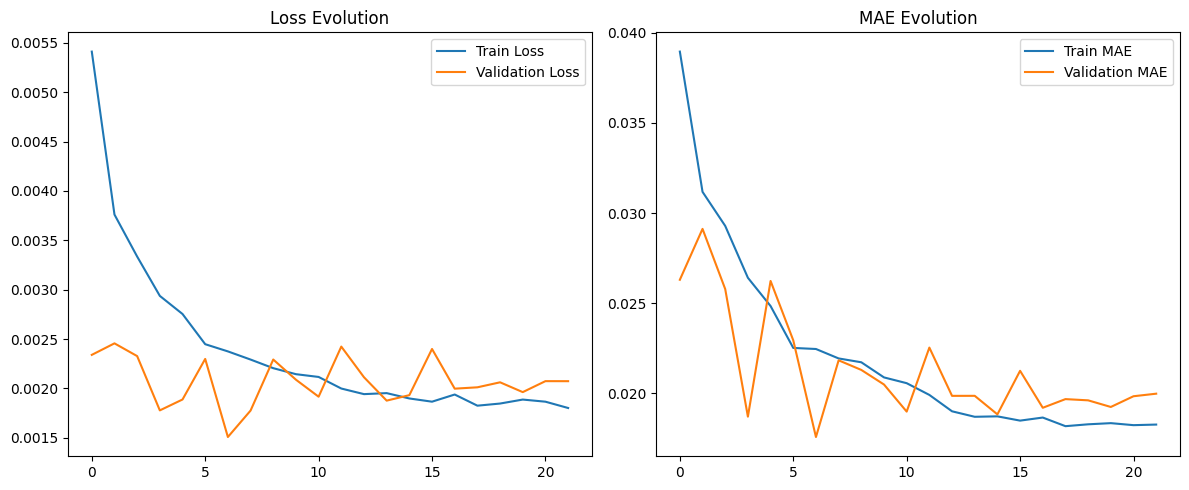

131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
LSTM RMSE: 1311.23
LSTM NSE: 0.7849
LSTM R² : 0.7849


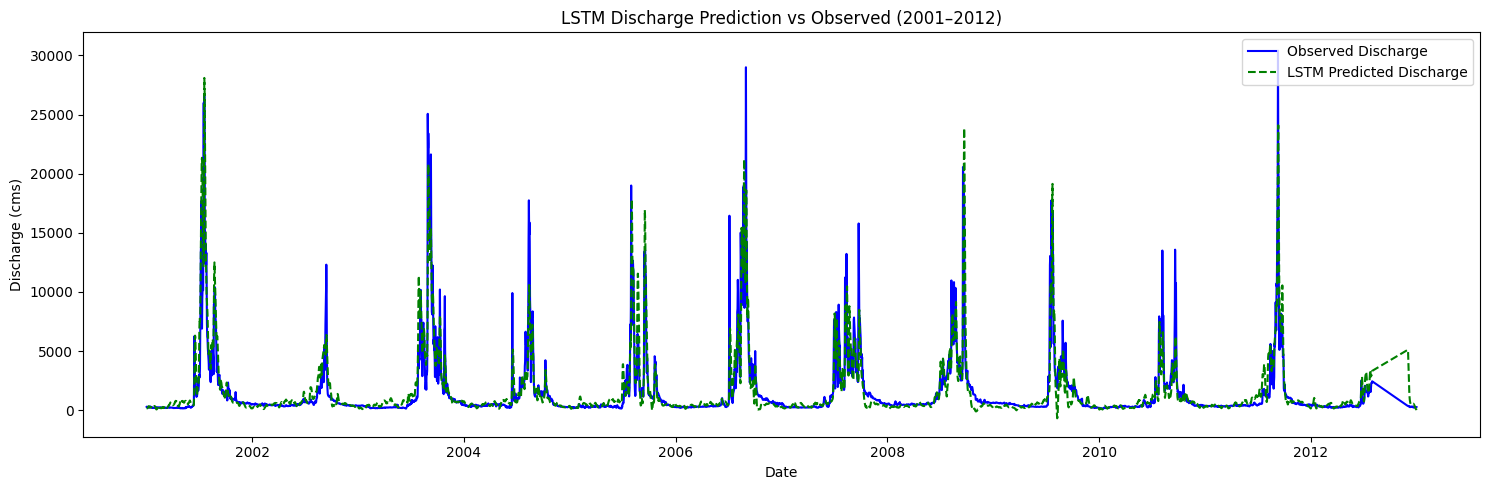

KeyboardInterrupt: 

In [14]:
# -------------------------------
# Step 1: Import libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.ensemble import RandomForestRegressor
import math

# -------------------------------
# Step 2: Load datasets and rename columns
# -------------------------------
temp_obs = pd.read_csv('/kaggle/input/original-observed-values/Temp_converted.csv', parse_dates=['Date'])
temp_obs.rename(columns={'Tikarpara_Calibration-rch-1-WTMPdegc': 'Temp_obs'}, inplace=True)

precip_obs = pd.read_csv('/kaggle/input/original-observed-values/daily_avg_precip.csv', parse_dates=['Date'])
precip_obs.rename(columns={'Avg_Precip_mm': 'Precip_obs'}, inplace=True)

obs_discharge = pd.read_csv('/kaggle/input/obs-discharge/Tikarpara_Obs_Discharge_Formatted.csv', parse_dates=['Date'])
obs_discharge.rename(columns={'Tikarpara_obs_discharge': 'Discharge_obs'}, inplace=True)

et_swat = pd.read_csv('/kaggle/input/swat-output-1/ET_converted.csv', parse_dates=['Date'])
et_swat.rename(columns={'Tikarpara_Calibration-rch-1-EVAPcms': 'ET_swat'}, inplace=True)

t_loss = pd.read_csv('/kaggle/input/swat-output-1/T_Loss_converted.csv', parse_dates=['Date'])
t_loss.rename(columns={'Tikarpara_Calibration-rch-1-TLOSScms': 'T_loss_swat'}, inplace=True)

flow_swat = pd.read_csv('/kaggle/input/swat-output-1/flow_out_1_converted.csv', parse_dates=['Date'])
flow_swat.rename(columns={'Tikarpara_Calibration-rch-1-FLOW_OUTcms': 'Flow_swat'}, inplace=True)

precip_swat = pd.read_csv('/kaggle/input/swat-output-1/obs_pred_trial_plot_prec.csv', parse_dates=['Date'])
precip_swat.rename(columns={'PRECIPmm': 'Precip_swat'}, inplace=True)

# -------------------------------
# Step 3: Merge all datasets
# -------------------------------
df = temp_obs.merge(precip_obs, on='Date')\
             .merge(obs_discharge, on='Date')\
             .merge(et_swat, on='Date')\
             .merge(t_loss, on='Date')\
             .merge(flow_swat, on='Date')\
             .merge(precip_swat[['Date', 'Precip_swat']], on='Date')

# -------------------------------
# Step 4: Drop missing values
# -------------------------------
df = df.dropna().reset_index(drop=True)

# -------------------------------
# Step 5: Define features and target
# -------------------------------
features = ['Temp_obs', 'Precip_obs', 'ET_swat', 'T_loss_swat', 'Flow_swat', 'Precip_swat']
target = 'Discharge_obs'

# -------------------------------
# Step 6: Scale features and target
# -------------------------------
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

df_scaled = df.copy()
df_scaled[features] = feature_scaler.fit_transform(df_scaled[features])
df_scaled[target] = target_scaler.fit_transform(df_scaled[[target]])

# -------------------------------
# Step 7: Create sequences (365-day lookback)
# -------------------------------
def create_sequences(data, target_col, sequence_length=365):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[features].iloc[i-sequence_length:i].values)
        y.append(data[target_col].iloc[i])
    return np.array(X), np.array(y)

X, y = create_sequences(df_scaled, target)
dates = df['Date'][365:]

# -------------------------------
# Step 8: Train-Test Split (Train: up to 2000, Test: 2001–2012)
# -------------------------------
train_end_date = pd.to_datetime('2000-12-31')
test_end_date = pd.to_datetime('2012-12-31')

train_idx = dates <= train_end_date
val_idx = (dates > train_end_date) & (dates <= test_end_date)

X_train_seq = X[train_idx]
y_train_seq = y[train_idx]
X_val_seq = X[val_idx]
y_val_seq = y[val_idx]

# -------------------------------
# Step 9: Build and Train LSTM Model
# -------------------------------
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(365, len(features))),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

history = model.fit(X_train_seq, y_train_seq,
                    epochs=250,
                    batch_size=64,
                    validation_data=(X_val_seq, y_val_seq),
                    callbacks=callbacks,
                    verbose=1)

# -------------------------------
# Step 10: Plot Training History
# -------------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Evolution')
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# Step 11: Evaluate LSTM Model
# -------------------------------
y_pred_scaled = model.predict(X_val_seq)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_val_actual = target_scaler.inverse_transform(y_val_seq.reshape(-1, 1))

lstm_rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred))
lstm_nse = 1 - np.sum((y_val_actual - y_pred)**2) / np.sum((y_val_actual - np.mean(y_val_actual))**2)
lstm_r2 = r2_score(y_val_actual, y_pred)

print(f'LSTM RMSE: {lstm_rmse:.2f}')
print(f'LSTM NSE: {lstm_nse:.4f}')
print(f'LSTM R² : {lstm_r2:.4f}')

# -------------------------------
# Step 12: Plot LSTM Predictions vs Observed (2001–2012)
# -------------------------------
val_dates = dates[val_idx]
plt.figure(figsize=(15, 5))
plt.plot(val_dates, y_val_actual, label='Observed Discharge', color='blue')
plt.plot(val_dates, y_pred, label='LSTM Predicted Discharge', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Discharge (cms)')
plt.title('LSTM Discharge Prediction vs Observed (2001–2012)')
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# Step 13: Random Forest Model for Comparison
# -------------------------------
# Flatten the sequence data for RF
X_train_flat = X_train_seq.reshape(X_train_seq.shape[0], -1)
X_val_flat = X_val_seq.reshape(X_val_seq.shape[0], -1)

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train_seq.ravel())

y_rf_pred = rf_model.predict(X_val_flat)
y_rf_pred_real = target_scaler.inverse_transform(y_rf_pred.reshape(-1, 1))

rf_rmse = np.sqrt(mean_squared_error(y_val_actual, y_rf_pred_real))
rf_nse = 1 - np.sum((y_val_actual - y_rf_pred_real)**2) / np.sum((y_val_actual - np.mean(y_val_actual))**2)
rf_r2 = r2_score(y_val_actual, y_rf_pred_real)

print(f'Random Forest RMSE: {rf_rmse:.2f}')
print(f'Random Forest NSE: {rf_nse:.4f}')
print(f'Random Forest R² : {rf_r2:.4f}')

# Plot RF predictions vs Observed
plt.figure(figsize=(15, 5))
plt.plot(val_dates, y_val_actual, label='Observed Discharge', color='blue')
plt.plot(val_dates, y_rf_pred_real, label='RF Predicted Discharge', color='orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Discharge (cms)')
plt.title('Random Forest Discharge Prediction vs Observed (2001–2012)')
plt.legend()
plt.tight_layout()
plt.show()


In [1]:
# -------------------------------
# Step 1: Import libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.ensemble import RandomForestRegressor
import math

# -------------------------------
# Step 2: Load datasets and rename columns
# -------------------------------
temp_obs = pd.read_csv('/kaggle/input/original-observed-values/Temp_converted.csv', parse_dates=['Date'])
temp_obs.rename(columns={'Tikarpara_Calibration-rch-1-WTMPdegc': 'Temp_obs'}, inplace=True)

precip_obs = pd.read_csv('/kaggle/input/original-observed-values/daily_avg_precip.csv', parse_dates=['Date'])
precip_obs.rename(columns={'Avg_Precip_mm': 'Precip_obs'}, inplace=True)

obs_discharge = pd.read_csv('/kaggle/input/obs-discharge/Tikarpara_Obs_Discharge_Formatted.csv', parse_dates=['Date'])
obs_discharge.rename(columns={'Tikarpara_obs_discharge': 'Discharge_obs'}, inplace=True)

et_swat = pd.read_csv('/kaggle/input/swat-output-1/ET_converted.csv', parse_dates=['Date'])
et_swat.rename(columns={'Tikarpara_Calibration-rch-1-EVAPcms': 'ET_swat'}, inplace=True)

t_loss = pd.read_csv('/kaggle/input/swat-output-1/T_Loss_converted.csv', parse_dates=['Date'])
t_loss.rename(columns={'Tikarpara_Calibration-rch-1-TLOSScms': 'T_loss_swat'}, inplace=True)

flow_swat = pd.read_csv('/kaggle/input/swat-output-1/flow_out_1_converted.csv', parse_dates=['Date'])
flow_swat.rename(columns={'Tikarpara_Calibration-rch-1-FLOW_OUTcms': 'Flow_swat'}, inplace=True)

precip_swat = pd.read_csv('/kaggle/input/swat-output-1/obs_pred_trial_plot_prec.csv', parse_dates=['Date'])
precip_swat.rename(columns={'PRECIPmm': 'Precip_swat'}, inplace=True)

# -------------------------------
# Step 3: Merge all datasets
# -------------------------------
df = temp_obs.merge(precip_obs, on='Date')\
             .merge(obs_discharge, on='Date')\
             .merge(et_swat, on='Date')\
             .merge(t_loss, on='Date')\
             .merge(flow_swat, on='Date')\
             .merge(precip_swat[['Date', 'Precip_swat']], on='Date')

# -------------------------------
# Step 4: Drop missing values
# -------------------------------
df = df.dropna().reset_index(drop=True)

# -------------------------------
# Step 5: Define features and target
# -------------------------------
features = ['Temp_obs', 'Precip_obs', 'ET_swat', 'T_loss_swat', 'Flow_swat', 'Precip_swat']
target = 'Discharge_obs'

# -------------------------------
# Step 6: Scale features and target
# -------------------------------
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

df_scaled = df.copy()
df_scaled[features] = feature_scaler.fit_transform(df_scaled[features])
df_scaled[target] = target_scaler.fit_transform(df_scaled[[target]])

# -------------------------------
# Step 7: Create sequences (365-day lookback)
# -------------------------------
def create_sequences(data, target_col, sequence_length=365):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[features].iloc[i-sequence_length:i].values)
        y.append(data[target_col].iloc[i])
    return np.array(X), np.array(y)

X, y = create_sequences(df_scaled, target)
dates = df['Date'][365:]

# -------------------------------
# Step 8: Train-Test Split (Train: up to 2000, Test: 2001–2012)
# -------------------------------
train_end_date = pd.to_datetime('2000-12-31')
test_end_date = pd.to_datetime('2012-12-31')

train_idx = dates <= train_end_date
val_idx = (dates > train_end_date) & (dates <= test_end_date)

X_train_seq = X[train_idx]
y_train_seq = y[train_idx]
X_val_seq = X[val_idx]
y_val_seq = y[val_idx]

# -------------------------------
# Step 9: Build and Train LSTM Model
# -------------------------------
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(365, len(features))),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

history = model.fit(X_train_seq, y_train_seq,
                    epochs=250,
                    batch_size=64,
                    validation_data=(X_val_seq, y_val_seq),
                    callbacks=callbacks,
                    verbose=1)

# -------------------------------
# Step 10: Plot Training History
# -------------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Evolution')
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# Step 11: Evaluate LSTM Model
# -------------------------------
y_pred_scaled = model.predict(X_val_seq)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_val_actual = target_scaler.inverse_transform(y_val_seq.reshape(-1, 1))

lstm_rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred))
lstm_nse = 1 - np.sum((y_val_actual - y_pred)**2) / np.sum((y_val_actual - np.mean(y_val_actual))**2)
lstm_r2 = r2_score(y_val_actual, y_pred)

print(f'LSTM RMSE: {lstm_rmse:.2f}')
print(f'LSTM NSE: {lstm_nse:.4f}')
print(f'LSTM R² : {lstm_r2:.4f}')

# -------------------------------
# Step 12: Plot LSTM Predictions vs Observed (2001–2012)
# -------------------------------
val_dates = dates[val_idx]
plt.figure(figsize=(15, 5))
plt.plot(val_dates, y_val_actual, label='Observed Discharge', color='blue')
plt.plot(val_dates, y_pred, label='LSTM Predicted Discharge', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Discharge (cms)')
plt.title('LSTM Discharge Prediction vs Observed (2001–2012)')
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# Step 13: Random Forest Model for Comparison
# -------------------------------
# Flatten the sequence data for RF
X_train_flat = X_train_seq.reshape(X_train_seq.shape[0], -1)
X_val_flat = X_val_seq.reshape(X_val_seq.shape[0], -1)

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train_seq.ravel())

y_rf_pred = rf_model.predict(X_val_flat)
y_rf_pred_real = target_scaler.inverse_transform(y_rf_pred.reshape(-1, 1))

rf_rmse = np.sqrt(mean_squared_error(y_val_actual, y_rf_pred_real))
rf_nse = 1 - np.sum((y_val_actual - y_rf_pred_real)**2) / np.sum((y_val_actual - np.mean(y_val_actual))**2)
rf_r2 = r2_score(y_val_actual, y_rf_pred_real)

print(f'Random Forest RMSE: {rf_rmse:.2f}')
print(f'Random Forest NSE: {rf_nse:.4f}')
print(f'Random Forest R² : {rf_r2:.4f}')

# Plot RF predictions vs Observed
plt.figure(figsize=(15, 5))
plt.plot(val_dates, y_val_actual, label='Observed Discharge', color='blue')
plt.plot(val_dates, y_rf_pred_real, label='RF Predicted Discharge', color='orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Discharge (cms)')
plt.title('Random Forest Discharge Prediction vs Observed (2001–2012)')
plt.legend()
plt.tight_layout()
plt.show()
# -------------------------------
# Step 1: Import libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.ensemble import RandomForestRegressor
import math

# -------------------------------
# Step 2: Load datasets and rename columns
# -------------------------------
temp_obs = pd.read_csv('/kaggle/input/original-observed-values/Temp_converted.csv', parse_dates=['Date'])
temp_obs.rename(columns={'Tikarpara_Calibration-rch-1-WTMPdegc': 'Temp_obs'}, inplace=True)

precip_obs = pd.read_csv('/kaggle/input/original-observed-values/daily_avg_precip.csv', parse_dates=['Date'])
precip_obs.rename(columns={'Avg_Precip_mm': 'Precip_obs'}, inplace=True)

obs_discharge = pd.read_csv('/kaggle/input/obs-discharge/Tikarpara_Obs_Discharge_Formatted.csv', parse_dates=['Date'])
obs_discharge.rename(columns={'Tikarpara_obs_discharge': 'Discharge_obs'}, inplace=True)

et_swat = pd.read_csv('/kaggle/input/swat-output-1/ET_converted.csv', parse_dates=['Date'])
et_swat.rename(columns={'Tikarpara_Calibration-rch-1-EVAPcms': 'ET_swat'}, inplace=True)

t_loss = pd.read_csv('/kaggle/input/swat-output-1/T_Loss_converted.csv', parse_dates=['Date'])
t_loss.rename(columns={'Tikarpara_Calibration-rch-1-TLOSScms': 'T_loss_swat'}, inplace=True)

flow_swat = pd.read_csv('/kaggle/input/swat-output-1/flow_out_1_converted.csv', parse_dates=['Date'])
flow_swat.rename(columns={'Tikarpara_Calibration-rch-1-FLOW_OUTcms': 'Flow_swat'}, inplace=True)

precip_swat = pd.read_csv('/kaggle/input/swat-output-1/obs_pred_trial_plot_prec.csv', parse_dates=['Date'])
precip_swat.rename(columns={'PRECIPmm': 'Precip_swat'}, inplace=True)

# -------------------------------
# Step 3: Merge all datasets
# -------------------------------
df = temp_obs.merge(precip_obs, on='Date')\
             .merge(obs_discharge, on='Date')\
             .merge(et_swat, on='Date')\
             .merge(t_loss, on='Date')\
             .merge(flow_swat, on='Date')\
             .merge(precip_swat[['Date', 'Precip_swat']], on='Date')

# -------------------------------
# Step 4: Drop missing values
# -------------------------------
df = df.dropna().reset_index(drop=True)

# -------------------------------
# Step 5: Define features and target
# -------------------------------
features = ['Temp_obs', 'Precip_obs', 'ET_swat', 'T_loss_swat', 'Flow_swat', 'Precip_swat']
target = 'Discharge_obs'

# -------------------------------
# Step 6: Scale features and target
# -------------------------------
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

df_scaled = df.copy()
df_scaled[features] = feature_scaler.fit_transform(df_scaled[features])
df_scaled[target] = target_scaler.fit_transform(df_scaled[[target]])

# -------------------------------
# Step 7: Create sequences (365-day lookback)
# -------------------------------
def create_sequences(data, target_col, sequence_length=365):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[features].iloc[i-sequence_length:i].values)
        y.append(data[target_col].iloc[i])
    return np.array(X), np.array(y)

X, y = create_sequences(df_scaled, target)
dates = df['Date'][365:]

# -------------------------------
# Step 8: Train-Test Split (Train: up to 2000, Test: 2001–2012)
# -------------------------------
train_end_date = pd.to_datetime('2000-12-31')
test_end_date = pd.to_datetime('2012-12-31')

train_idx = dates <= train_end_date
val_idx = (dates > train_end_date) & (dates <= test_end_date)

X_train_seq = X[train_idx]
y_train_seq = y[train_idx]
X_val_seq = X[val_idx]
y_val_seq = y[val_idx]

# -------------------------------
# Step 9: Build and Train LSTM Model
# -------------------------------
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(365, len(features))),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

history = model.fit(X_train_seq, y_train_seq,
                    epochs=250,
                    batch_size=64,
                    validation_data=(X_val_seq, y_val_seq),
                    callbacks=callbacks,
                    verbose=1)

# -------------------------------
# Step 10: Plot Training History
# -------------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Evolution')
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# Step 11: Evaluate LSTM Model
# -------------------------------
y_pred_scaled = model.predict(X_val_seq)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_val_actual = target_scaler.inverse_transform(y_val_seq.reshape(-1, 1))

lstm_rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred))
lstm_nse = 1 - np.sum((y_val_actual - y_pred)**2) / np.sum((y_val_actual - np.mean(y_val_actual))**2)
lstm_r2 = r2_score(y_val_actual, y_pred)

print(f'LSTM RMSE: {lstm_rmse:.2f}')
print(f'LSTM NSE: {lstm_nse:.4f}')
print(f'LSTM R² : {lstm_r2:.4f}')

# -------------------------------
# Step 12: Plot LSTM Predictions vs Observed (2001–2012)
# -------------------------------
val_dates = dates[val_idx]
plt.figure(figsize=(15, 5))
plt.plot(val_dates, y_val_actual, label='Observed Discharge', color='blue')
plt.plot(val_dates, y_pred, label='LSTM Predicted Discharge', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Discharge (cms)')
plt.title('LSTM Discharge Prediction vs Observed (2001–2012)')
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# Step 13: Random Forest Model for Comparison
# -------------------------------
# Flatten the sequence data for RF
X_train_flat = X_train_seq.reshape(X_train_seq.shape[0], -1)
X_val_flat = X_val_seq.reshape(X_val_seq.shape[0], -1)

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train_seq.ravel())

y_rf_pred = rf_model.predict(X_val_flat)
y_rf_pred_real = target_scaler.inverse_transform(y_rf_pred.reshape(-1, 1))

rf_rmse = np.sqrt(mean_squared_error(y_val_actual, y_rf_pred_real))
rf_nse = 1 - np.sum((y_val_actual - y_rf_pred_real)**2) / np.sum((y_val_actual - np.mean(y_val_actual))**2)
rf_r2 = r2_score(y_val_actual, y_rf_pred_real)

print(f'Random Forest RMSE: {rf_rmse:.2f}')
print(f'Random Forest NSE: {rf_nse:.4f}')
print(f'Random Forest R² : {rf_r2:.4f}')

# Plot RF predictions vs Observed
plt.figure(figsize=(15, 5))
plt.plot(val_dates, y_val_actual, label='Observed Discharge', color='blue')
plt.plot(val_dates, y_rf_pred_real, label='RF Predicted Discharge', color='orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Discharge (cms)')
plt.title('Random Forest Discharge Prediction vs Observed (2001–2012)')
plt.legend()
plt.tight_layout()
plt.show()


2025-04-19 19:10:58.713252: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745089858.975536      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745089859.054039      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1745089884.578221      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745089884.578869      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

Epoch 1/250


I0000 00:00:1745089889.657255     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.0070 - mae: 0.0438 - val_loss: 0.0024 - val_mae: 0.0288 - learning_rate: 5.0000e-04
Epoch 2/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0038 - mae: 0.0314 - val_loss: 0.0020 - val_mae: 0.0222 - learning_rate: 5.0000e-04
Epoch 3/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0035 - mae: 0.0292 - val_loss: 0.0023 - val_mae: 0.0252 - learning_rate: 5.0000e-04
Epoch 4/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0030 - mae: 0.0271 - val_loss: 0.0019 - val_mae: 0.0220 - learning_rate: 5.0000e-04
Epoch 5/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0027 - mae: 0.0253 - val_loss: 0.0019 - val_mae: 0.0222 - learning_rate: 5.0000e-04
Epoch 6/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0026 - mae: 0.0239 - val_loss: 0.0019 - val_mae: 0.0205 - learning_rate: 5.0000e-04
Epoch 7/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0025 - mae: 0.0239 - val_loss: 0.0027 - val_mae: 0.0232 - le

KeyboardInterrupt: 

 SWAT Model Performance (1951–2013):
NSE     : -0.5447
R²      : -0.5447
RMSE    : 3885.93 m³/s
PBIAS   : 94.67 %


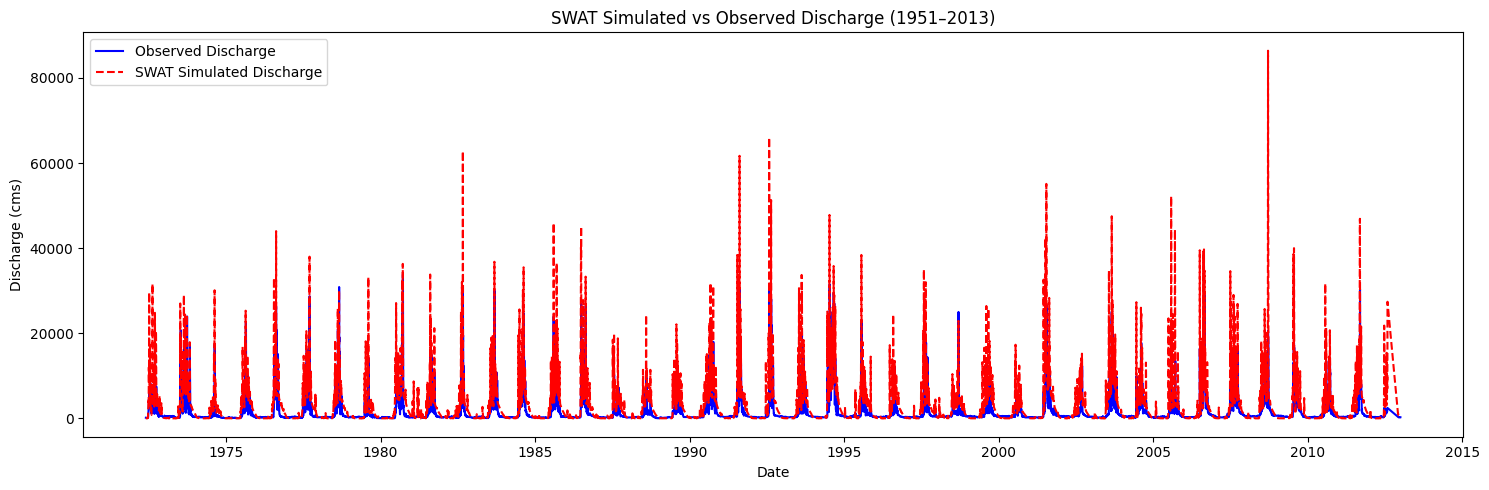

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Load datasets
obs_df = pd.read_csv('/kaggle/input/obs-discharge/Tikarpara_Obs_Discharge_Formatted.csv', parse_dates=['Date'])
swat_df = pd.read_csv('/kaggle/input/swat-output-1/flow_out_1_converted.csv', parse_dates=['Date'])

# Rename columns
obs_df.rename(columns={'Tikarpara_obs_discharge': 'Discharge_obs'}, inplace=True)
swat_df.rename(columns={'Tikarpara_Calibration-rch-1-FLOW_OUTcms': 'Discharge_swat'}, inplace=True)

# Merge datasets on date
merged = pd.merge(obs_df, swat_df, on='Date')
merged = merged.dropna()

# Filter full date range (safeguard for noisy/misaligned inputs)
merged = merged[(merged['Date'] >= '1951-01-01') & (merged['Date'] <= '2013-11-30')]

# Extract arrays
obs = merged['Discharge_obs'].values
sim = merged['Discharge_swat'].values
dates = merged['Date']

# Compute metrics
nse = 1 - np.sum((obs - sim) ** 2) / np.sum((obs - np.mean(obs)) ** 2)
r2 = r2_score(obs, sim)
rmse = np.sqrt(mean_squared_error(obs, sim))
pbias = 100 * (np.sum(sim - obs) / np.sum(obs))

# Print metrics
print(" SWAT Model Performance (1951–2013):")
print(f"NSE     : {nse:.4f}")
print(f"R²      : {r2:.4f}")
print(f"RMSE    : {rmse:.2f} m³/s")
print(f"PBIAS   : {pbias:.2f} %")

# Plot observed vs simulated
plt.figure(figsize=(15, 5))
plt.plot(dates, obs, label='Observed Discharge', color='blue')
plt.plot(dates, sim, label='SWAT Simulated Discharge', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Discharge (cms)')
plt.title('SWAT Simulated vs Observed Discharge (1951–2013)')
plt.legend()
plt.tight_layout()
plt.show()


Calibration Period

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0072 - mae: 0.0459 - val_loss: 0.0026 - val_mae: 0.0320 - learning_rate: 5.0000e-04
Epoch 2/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0038 - mae: 0.0317 - val_loss: 0.0021 - val_mae: 0.0243 - learning_rate: 5.0000e-04
Epoch 3/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0034 - mae: 0.0292 - val_loss: 0.0020 - val_mae: 0.0216 - learning_rate: 5.0000e-04
Epoch 4/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0033 - mae: 0.0274 - val_loss: 0.0028 - val_mae: 0.0250 - learning_rate: 5.0000e-04
Epoch 5/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0027 - mae: 0.0244 - val_loss: 0.0029 - val_mae: 0.0256 - learning_rate: 5.0000e-04
Epoch 6/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0025 - mae: 0.0233 - val_loss: 0.0026 - val_mae: 0.0233 - learning_rate: 5.0000e-04
Epoch 7/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0022 - mae: 0.0221 - val_loss: 0.0018 - val_mae:

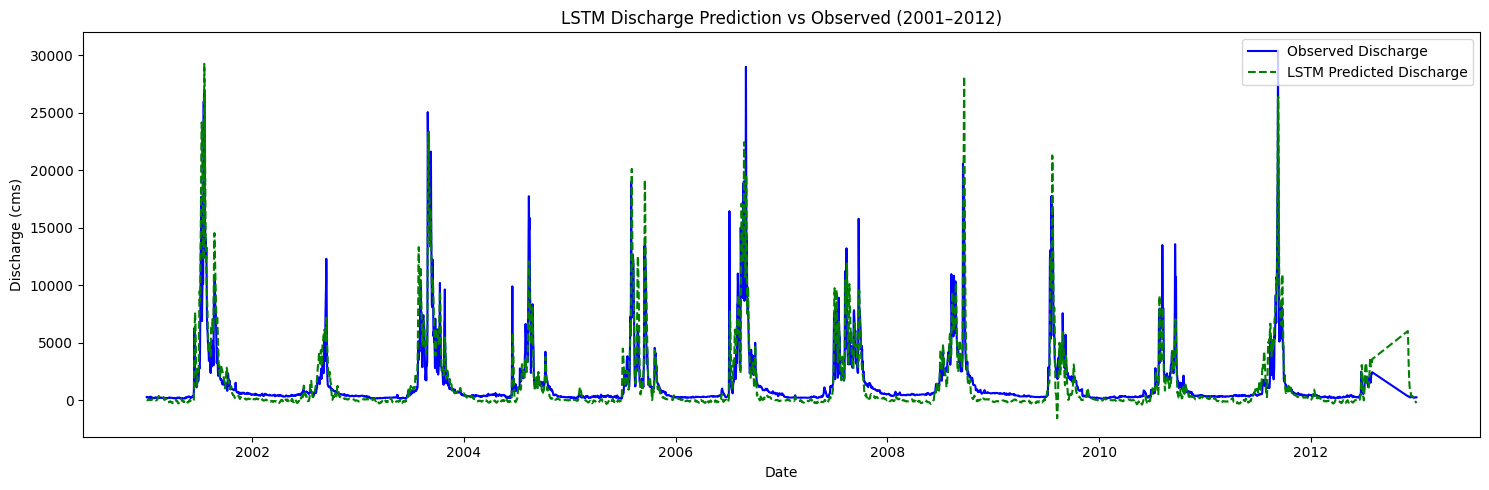

In [3]:
# -------------------------------
# Step 1: Import libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.ensemble import RandomForestRegressor

# -------------------------------
# Step 2: Load datasets and rename columns
# -------------------------------
temp_obs = pd.read_csv('/kaggle/input/original-observed-values/Temp_converted.csv', parse_dates=['Date'])
temp_obs.rename(columns={'Tikarpara_Calibration-rch-1-WTMPdegc': 'Temp_obs'}, inplace=True)

precip_obs = pd.read_csv('/kaggle/input/original-observed-values/daily_avg_precip.csv', parse_dates=['Date'])
precip_obs.rename(columns={'Avg_Precip_mm': 'Precip_obs'}, inplace=True)

obs_discharge = pd.read_csv('/kaggle/input/obs-discharge/Tikarpara_Obs_Discharge_Formatted.csv', parse_dates=['Date'])
obs_discharge.rename(columns={'Tikarpara_obs_discharge': 'Discharge_obs'}, inplace=True)

et_swat = pd.read_csv('/kaggle/input/swat-output-1/ET_converted.csv', parse_dates=['Date'])
et_swat.rename(columns={'Tikarpara_Calibration-rch-1-EVAPcms': 'ET_swat'}, inplace=True)

t_loss = pd.read_csv('/kaggle/input/swat-output-1/T_Loss_converted.csv', parse_dates=['Date'])
t_loss.rename(columns={'Tikarpara_Calibration-rch-1-TLOSScms': 'T_loss_swat'}, inplace=True)

flow_swat = pd.read_csv('/kaggle/input/swat-output-1/flow_out_1_converted.csv', parse_dates=['Date'])
flow_swat.rename(columns={'Tikarpara_Calibration-rch-1-FLOW_OUTcms': 'Flow_swat'}, inplace=True)

precip_swat = pd.read_csv('/kaggle/input/swat-output-1/obs_pred_trial_plot_prec.csv', parse_dates=['Date'])
precip_swat.rename(columns={'PRECIPmm': 'Precip_swat'}, inplace=True)

# -------------------------------
# Step 3: Merge all datasets
# -------------------------------
df = temp_obs.merge(precip_obs, on='Date')\
             .merge(obs_discharge, on='Date')\
             .merge(et_swat, on='Date')\
             .merge(t_loss, on='Date')\
             .merge(flow_swat, on='Date')\
             .merge(precip_swat[['Date', 'Precip_swat']], on='Date')

# -------------------------------
# Step 4: Drop missing values
# -------------------------------
df = df.dropna().reset_index(drop=True)

# -------------------------------
# Step 5: Define features and target
# -------------------------------
features = ['Temp_obs', 'Precip_obs', 'ET_swat', 'T_loss_swat', 'Flow_swat', 'Precip_swat']
target = 'Discharge_obs'

# -------------------------------
# Step 6: Scale features and target
# -------------------------------
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

df_scaled = df.copy()
df_scaled[features] = feature_scaler.fit_transform(df_scaled[features])
df_scaled[target] = target_scaler.fit_transform(df_scaled[[target]])

# -------------------------------
# Step 7: Create sequences (365-day lookback)
# -------------------------------
def create_sequences(data, target_col, sequence_length=365):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[features].iloc[i-sequence_length:i].values)
        y.append(data[target_col].iloc[i])
    return np.array(X), np.array(y)

X, y = create_sequences(df_scaled, target)
dates = df['Date'][365:]

# -------------------------------
# Step 8: Train-Test Split (Train: up to 2000, Test: 2001–2012)
# -------------------------------
train_end_date = pd.to_datetime('2000-12-31')
test_end_date = pd.to_datetime('2012-12-31')

train_idx = dates <= train_end_date
val_idx = (dates > train_end_date) & (dates <= test_end_date)

X_train_seq = X[train_idx]
y_train_seq = y[train_idx]
X_val_seq = X[val_idx]
y_val_seq = y[val_idx]

# -------------------------------
# Step 9: Build and Train LSTM Model
# -------------------------------
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(365, len(features))),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

history = model.fit(X_train_seq, y_train_seq,
                    epochs=250,
                    batch_size=64,
                    validation_data=(X_val_seq, y_val_seq),
                    callbacks=callbacks,
                    verbose=1)

# -------------------------------
# Step 10: Evaluate on Calibration Period
# -------------------------------
y_train_pred_scaled = model.predict(X_train_seq)
y_train_pred = target_scaler.inverse_transform(y_train_pred_scaled)
y_train_actual = target_scaler.inverse_transform(y_train_seq.reshape(-1, 1))

cal_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
cal_nse = 1 - np.sum((y_train_actual - y_train_pred)**2) / np.sum((y_train_actual - np.mean(y_train_actual))**2)
cal_r2 = r2_score(y_train_actual, y_train_pred)

print(f'Calibration RMSE: {cal_rmse:.2f}')
print(f'Calibration NSE: {cal_nse:.4f}')
print(f'Calibration R² : {cal_r2:.4f}')

# -------------------------------
# Step 11: Evaluate on Validation Period
# -------------------------------
y_pred_scaled = model.predict(X_val_seq)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_val_actual = target_scaler.inverse_transform(y_val_seq.reshape(-1, 1))

lstm_rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred))
lstm_nse = 1 - np.sum((y_val_actual - y_pred)**2) / np.sum((y_val_actual - np.mean(y_val_actual))**2)
lstm_r2 = r2_score(y_val_actual, y_pred)

print(f'LSTM RMSE: {lstm_rmse:.2f}')
print(f'LSTM NSE: {lstm_nse:.4f}')
print(f'LSTM R² : {lstm_r2:.4f}')

# -------------------------------
# Step 12: Plot Predictions
# -------------------------------
val_dates = dates[val_idx]
plt.figure(figsize=(15, 5))
plt.plot(val_dates, y_val_actual, label='Observed Discharge', color='blue')
plt.plot(val_dates, y_pred, label='LSTM Predicted Discharge', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Discharge (cms)')
plt.title('LSTM Discharge Prediction vs Observed (2001–2012)')
plt.legend()
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0058 - mae: 0.0394 - val_loss: 0.0033 - val_mae: 0.0362 - learning_rate: 5.0000e-04
Epoch 2/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0041 - mae: 0.0342 - val_loss: 0.0022 - val_mae: 0.0278 - learning_rate: 5.0000e-04
Epoch 3/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0036 - mae: 0.0304 - val_loss: 0.0023 - val_mae: 0.0316 - learning_rate: 5.0000e-04
Epoch 4/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0030 - mae: 0.0264 - val_loss: 0.0022 - val_mae: 0.0237 - learning_rate: 5.0000e-04
Epoch 5/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0029 - mae: 0.0257 - val_loss: 0.0022 - val_mae: 0.0292 - learning_rate: 5.0000e-04
Epoch 6/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0023 - mae: 0.0225 - val_loss: 0.0016 - val_mae: 0.0203 - learning_rate: 5.0000e-04
Epoch 7/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0024 - mae: 0.0227 - val_loss: 0.0020 - val_mae:

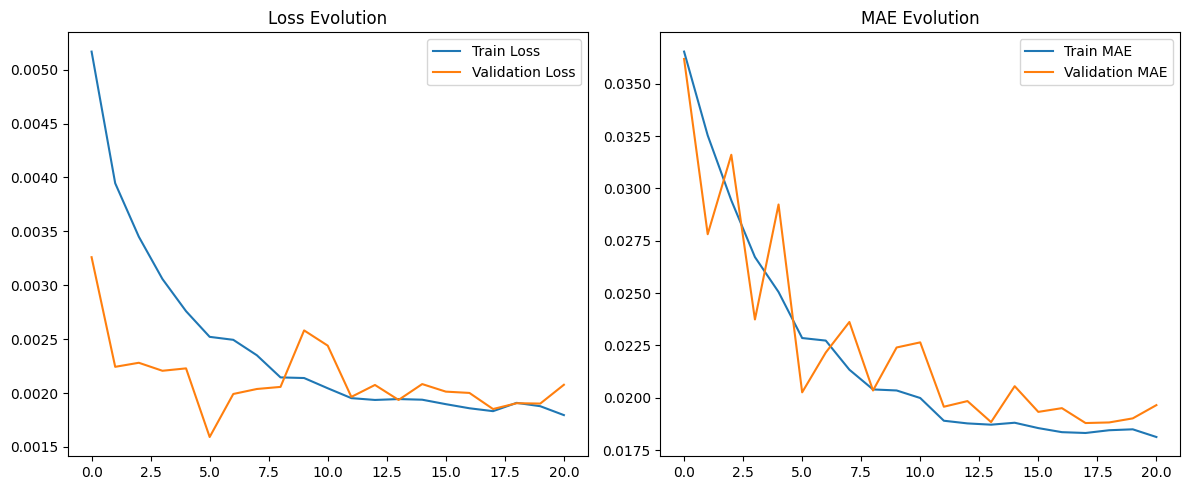

131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
LSTM RMSE: 1347.75
LSTM NSE: 0.7727
LSTM R² : 0.7727


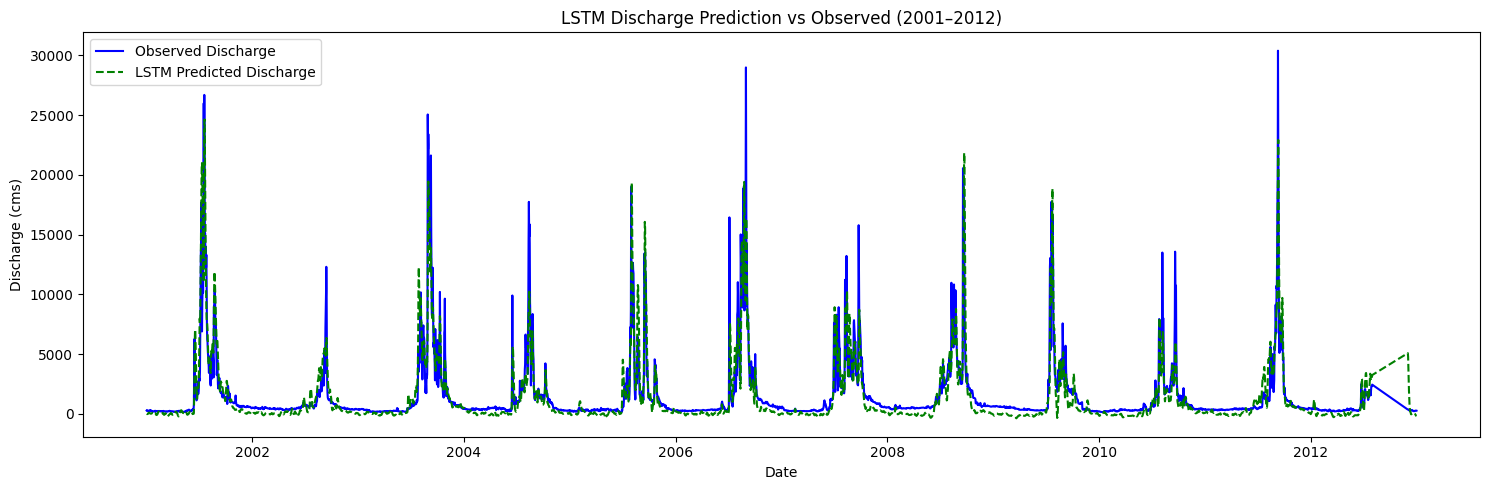

KeyboardInterrupt: 

In [8]:
# -------------------------------
# Step 1: Import libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.ensemble import RandomForestRegressor
import math

# -------------------------------
# Step 2: Load datasets and rename columns
# -------------------------------
temp_obs = pd.read_csv('/kaggle/input/original-observed-values/Temp_converted.csv', parse_dates=['Date'])
temp_obs.rename(columns={'Tikarpara_Calibration-rch-1-WTMPdegc': 'Temp_obs'}, inplace=True)

precip_obs = pd.read_csv('/kaggle/input/original-observed-values/daily_avg_precip.csv', parse_dates=['Date'])
precip_obs.rename(columns={'Avg_Precip_mm': 'Precip_obs'}, inplace=True)

obs_discharge = pd.read_csv('/kaggle/input/obs-discharge/Tikarpara_Obs_Discharge_Formatted.csv', parse_dates=['Date'])
obs_discharge.rename(columns={'Tikarpara_obs_discharge': 'Discharge_obs'}, inplace=True)

et_swat = pd.read_csv('/kaggle/input/swat-output-1/ET_converted.csv', parse_dates=['Date'])
et_swat.rename(columns={'Tikarpara_Calibration-rch-1-EVAPcms': 'ET_swat'}, inplace=True)

t_loss = pd.read_csv('/kaggle/input/swat-output-1/T_Loss_converted.csv', parse_dates=['Date'])
t_loss.rename(columns={'Tikarpara_Calibration-rch-1-TLOSScms': 'T_loss_swat'}, inplace=True)

flow_swat = pd.read_csv('/kaggle/input/swat-output-1/flow_out_1_converted.csv', parse_dates=['Date'])
flow_swat.rename(columns={'Tikarpara_Calibration-rch-1-FLOW_OUTcms': 'Flow_swat'}, inplace=True)

precip_swat = pd.read_csv('/kaggle/input/swat-output-1/obs_pred_trial_plot_prec.csv', parse_dates=['Date'])
precip_swat.rename(columns={'PRECIPmm': 'Precip_swat'}, inplace=True)

# -------------------------------
# Step 3: Merge all datasets
# -------------------------------
df = temp_obs.merge(precip_obs, on='Date')\
             .merge(obs_discharge, on='Date')\
             .merge(et_swat, on='Date')\
             .merge(t_loss, on='Date')\
             .merge(flow_swat, on='Date')\
             .merge(precip_swat[['Date', 'Precip_swat']], on='Date')

# -------------------------------
# Step 4: Drop missing values
# -------------------------------
df = df.dropna().reset_index(drop=True)

# -------------------------------
# Step 5: Define features and target
# -------------------------------
features = ['Temp_obs', 'Precip_obs', 'ET_swat', 'T_loss_swat', 'Flow_swat', 'Precip_swat']
target = 'Discharge_obs'

# -------------------------------
# Step 6: Scale features and target
# -------------------------------
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

df_scaled = df.copy()
df_scaled[features] = feature_scaler.fit_transform(df_scaled[features])
df_scaled[target] = target_scaler.fit_transform(df_scaled[[target]])

# -------------------------------
# Step 7: Create sequences (365-day lookback)
# -------------------------------
def create_sequences(data, target_col, sequence_length=365):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[features].iloc[i-sequence_length:i].values)
        y.append(data[target_col].iloc[i])
    return np.array(X), np.array(y)

X, y = create_sequences(df_scaled, target)
dates = df['Date'][365:]

# -------------------------------
# Step 8: Train-Test Split (Train: up to 2000, Test: 2001–2012)
# -------------------------------
train_end_date = pd.to_datetime('2000-12-31')
test_end_date = pd.to_datetime('2012-12-31')

train_idx = dates <= train_end_date
val_idx = (dates > train_end_date) & (dates <= test_end_date)

X_train_seq = X[train_idx]
y_train_seq = y[train_idx]
X_val_seq = X[val_idx]
y_val_seq = y[val_idx]

# -------------------------------
# Step 9: Build and Train LSTM Model
# -------------------------------
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(365, len(features))),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

history = model.fit(X_train_seq, y_train_seq,
                    epochs=250,
                    batch_size=64,
                    validation_data=(X_val_seq, y_val_seq),
                    callbacks=callbacks,
                    verbose=1)

# -------------------------------
# Step 10: Plot Training History
# -------------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Evolution')
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# Step 11: Evaluate LSTM Model
# -------------------------------
y_pred_scaled = model.predict(X_val_seq)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_val_actual = target_scaler.inverse_transform(y_val_seq.reshape(-1, 1))

lstm_rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred))
lstm_nse = 1 - np.sum((y_val_actual - y_pred)**2) / np.sum((y_val_actual - np.mean(y_val_actual))**2)
lstm_r2 = r2_score(y_val_actual, y_pred)

print(f'LSTM RMSE: {lstm_rmse:.2f}')
print(f'LSTM NSE: {lstm_nse:.4f}')
print(f'LSTM R² : {lstm_r2:.4f}')

# -------------------------------
# Step 12: Plot LSTM Predictions vs Observed (2001–2012)
# -------------------------------
val_dates = dates[val_idx]
plt.figure(figsize=(15, 5))
plt.plot(val_dates, y_val_actual, label='Observed Discharge', color='blue')
plt.plot(val_dates, y_pred, label='LSTM Predicted Discharge', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Discharge (cms)')
plt.title('LSTM Discharge Prediction vs Observed (2001–2012)')
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# Step 13: Random Forest Model for Comparison
# -------------------------------
# Flatten the sequence data for RF
X_train_flat = X_train_seq.reshape(X_train_seq.shape[0], -1)
X_val_flat = X_val_seq.reshape(X_val_seq.shape[0], -1)

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train_seq.ravel())

y_rf_pred = rf_model.predict(X_val_flat)
y_rf_pred_real = target_scaler.inverse_transform(y_rf_pred.reshape(-1, 1))

rf_rmse = np.sqrt(mean_squared_error(y_val_actual, y_rf_pred_real))
rf_nse = 1 - np.sum((y_val_actual - y_rf_pred_real)**2) / np.sum((y_val_actual - np.mean(y_val_actual))**2)
rf_r2 = r2_score(y_val_actual, y_rf_pred_real)

print(f'Random Forest RMSE: {rf_rmse:.2f}')
print(f'Random Forest NSE: {rf_nse:.4f}')
print(f'Random Forest R² : {rf_r2:.4f}')

# Plot RF predictions vs Observed
plt.figure(figsize=(15, 5))
plt.plot(val_dates, y_val_actual, label='Observed Discharge', color='blue')
plt.plot(val_dates, y_rf_pred_real, label='RF Predicted Discharge', color='orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Discharge (cms)')
plt.title('Random Forest Discharge Prediction vs Observed (2001–2012)')
plt.legend()
plt.tight_layout()
plt.show()
# -------------------------------
# Step 1: Import libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.ensemble import RandomForestRegressor
import math

# -------------------------------
# Step 2: Load datasets and rename columns
# -------------------------------
temp_obs = pd.read_csv('/kaggle/input/original-observed-values/Temp_converted.csv', parse_dates=['Date'])
temp_obs.rename(columns={'Tikarpara_Calibration-rch-1-WTMPdegc': 'Temp_obs'}, inplace=True)

precip_obs = pd.read_csv('/kaggle/input/original-observed-values/daily_avg_precip.csv', parse_dates=['Date'])
precip_obs.rename(columns={'Avg_Precip_mm': 'Precip_obs'}, inplace=True)

obs_discharge = pd.read_csv('/kaggle/input/obs-discharge/Tikarpara_Obs_Discharge_Formatted.csv', parse_dates=['Date'])
obs_discharge.rename(columns={'Tikarpara_obs_discharge': 'Discharge_obs'}, inplace=True)

et_swat = pd.read_csv('/kaggle/input/swat-output-1/ET_converted.csv', parse_dates=['Date'])
et_swat.rename(columns={'Tikarpara_Calibration-rch-1-EVAPcms': 'ET_swat'}, inplace=True)

t_loss = pd.read_csv('/kaggle/input/swat-output-1/T_Loss_converted.csv', parse_dates=['Date'])
t_loss.rename(columns={'Tikarpara_Calibration-rch-1-TLOSScms': 'T_loss_swat'}, inplace=True)

flow_swat = pd.read_csv('/kaggle/input/swat-output-1/flow_out_1_converted.csv', parse_dates=['Date'])
flow_swat.rename(columns={'Tikarpara_Calibration-rch-1-FLOW_OUTcms': 'Flow_swat'}, inplace=True)

precip_swat = pd.read_csv('/kaggle/input/swat-output-1/obs_pred_trial_plot_prec.csv', parse_dates=['Date'])
precip_swat.rename(columns={'PRECIPmm': 'Precip_swat'}, inplace=True)

# -------------------------------
# Step 3: Merge all datasets
# -------------------------------
df = temp_obs.merge(precip_obs, on='Date')\
             .merge(obs_discharge, on='Date')\
             .merge(et_swat, on='Date')\
             .merge(t_loss, on='Date')\
             .merge(flow_swat, on='Date')\
             .merge(precip_swat[['Date', 'Precip_swat']], on='Date')

# -------------------------------
# Step 4: Drop missing values
# -------------------------------
df = df.dropna().reset_index(drop=True)

# -------------------------------
# Step 5: Define features and target
# -------------------------------
features = ['Temp_obs', 'Precip_obs', 'ET_swat', 'T_loss_swat', 'Flow_swat', 'Precip_swat']
target = 'Discharge_obs'

# -------------------------------
# Step 6: Scale features and target
# -------------------------------
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

df_scaled = df.copy()
df_scaled[features] = feature_scaler.fit_transform(df_scaled[features])
df_scaled[target] = target_scaler.fit_transform(df_scaled[[target]])

# -------------------------------
# Step 7: Create sequences (365-day lookback)
# -------------------------------
def create_sequences(data, target_col, sequence_length=365):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[features].iloc[i-sequence_length:i].values)
        y.append(data[target_col].iloc[i])
    return np.array(X), np.array(y)

X, y = create_sequences(df_scaled, target)
dates = df['Date'][365:]

# -------------------------------
# Step 8: Train-Test Split (Train: up to 2000, Test: 2001–2012)
# -------------------------------
train_end_date = pd.to_datetime('2000-12-31')
test_end_date = pd.to_datetime('2012-12-31')

train_idx = dates <= train_end_date
val_idx = (dates > train_end_date) & (dates <= test_end_date)

X_train_seq = X[train_idx]
y_train_seq = y[train_idx]
X_val_seq = X[val_idx]
y_val_seq = y[val_idx]

# -------------------------------
# Step 9: Build and Train LSTM Model
# -------------------------------
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(365, len(features))),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

history = model.fit(X_train_seq, y_train_seq,
                    epochs=250,
                    batch_size=64,
                    validation_data=(X_val_seq, y_val_seq),
                    callbacks=callbacks,
                    verbose=1)

# -------------------------------
# Step 10: Plot Training History
# -------------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Evolution')
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# Step 11: Evaluate LSTM Model
# -------------------------------
y_pred_scaled = model.predict(X_val_seq)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_val_actual = target_scaler.inverse_transform(y_val_seq.reshape(-1, 1))

lstm_rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred))
lstm_nse = 1 - np.sum((y_val_actual - y_pred)**2) / np.sum((y_val_actual - np.mean(y_val_actual))**2)
lstm_r2 = r2_score(y_val_actual, y_pred)

print(f'LSTM RMSE: {lstm_rmse:.2f}')
print(f'LSTM NSE: {lstm_nse:.4f}')
print(f'LSTM R² : {lstm_r2:.4f}')

# -------------------------------
# Step 12: Plot LSTM Predictions vs Observed (2001–2012)
# -------------------------------
val_dates = dates[val_idx]
plt.figure(figsize=(15, 5))
plt.plot(val_dates, y_val_actual, label='Observed Discharge', color='blue')
plt.plot(val_dates, y_pred, label='LSTM Predicted Discharge', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Discharge (cms)')
plt.title('LSTM Discharge Prediction vs Observed (2001–2012)')
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# -------------------------------
# Step 13: Random Forest Model – Calibration & Validation Metrics
# -------------------------------

# Flatten the sequence data for RF
X_train_flat = X_train_seq.reshape(X_train_seq.shape[0], -1)
X_val_flat   = X_val_seq.reshape(X_val_seq.shape[0], -1)

# Train RF
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train_seq.ravel())

# Predict on both periods
y_rf_train_pred = rf_model.predict(X_train_flat)
y_rf_val_pred   = rf_model.predict(X_val_flat)

# Inverse‐scale to original discharge units
y_train_actual      = target_scaler.inverse_transform(y_train_seq.reshape(-1, 1))
y_val_actual        = target_scaler.inverse_transform(y_val_seq.reshape(-1, 1))
y_rf_train_pred_real = target_scaler.inverse_transform(y_rf_train_pred.reshape(-1, 1))
y_rf_val_pred_real   = target_scaler.inverse_transform(y_rf_val_pred.reshape(-1, 1))

# Define NSE and PBIAS
def nse(obs, sim):
    return 1 - np.sum((obs - sim)**2) / np.sum((obs - np.mean(obs))**2)

def pbias(obs, sim):
    return 100 * np.sum(sim - obs) / np.sum(obs)

# Calibration metrics
rf_cal_r2    = r2_score(y_train_actual,      y_rf_train_pred_real)
rf_cal_nse   = nse(     y_train_actual.flatten(), y_rf_train_pred_real.flatten())
rf_cal_pbias = pbias(   y_train_actual.flatten(), y_rf_train_pred_real.flatten())

# Validation metrics
rf_val_r2    = r2_score(y_val_actual,        y_rf_val_pred_real)
rf_val_nse   = nse(     y_val_actual.flatten(),   y_rf_val_pred_real.flatten())
rf_val_pbias = pbias(   y_val_actual.flatten(),   y_rf_val_pred_real.flatten())

# Print out
print("\nRandom Forest Performance")
print("— Calibration —")
print(f"R²     : {rf_cal_r2:.4f}")
print(f"NSE    : {rf_cal_nse:.4f}")
print(f"PBIAS  : {rf_cal_pbias:.2f} %")

print("\n— Validation —")
print(f"R²     : {rf_val_r2:.4f}")
print(f"NSE    : {rf_val_nse:.4f}")
print(f"PBIAS  : {rf_val_pbias:.2f} %")

# (Optional) plot validation predictions vs observed
val_dates = dates[val_idx]
plt.figure(figsize=(15,5))
plt.plot(val_dates, y_val_actual,        label='Observed', color='blue')
plt.plot(val_dates, y_rf_val_pred_real,  label='RF Predicted', color='orange', linestyle='--')
plt.xlabel('Date'); plt.ylabel('Discharge (cms)')
plt.title('RF Prediction vs Observed (2001–2012)')
plt.legend(); plt.tight_layout(); plt.show()

# -------------------------------
# Step 13: Random Forest Model – Calibration & Validation Metrics
# -------------------------------

# Flatten the sequence data for RF
X_train_flat = X_train_seq.reshape(X_train_seq.shape[0], -1)
X_val_flat   = X_val_seq.reshape(X_val_seq.shape[0], -1)

# Train RF
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train_seq.ravel())

# Predict on both periods
y_rf_train_pred = rf_model.predict(X_train_flat)
y_rf_val_pred   = rf_model.predict(X_val_flat)

# Inverse‐scale to original discharge units
y_train_actual      = target_scaler.inverse_transform(y_train_seq.reshape(-1, 1))
y_val_actual        = target_scaler.inverse_transform(y_val_seq.reshape(-1, 1))
y_rf_train_pred_real = target_scaler.inverse_transform(y_rf_train_pred.reshape(-1, 1))
y_rf_val_pred_real   = target_scaler.inverse_transform(y_rf_val_pred.reshape(-1, 1))

# Define NSE and PBIAS
def nse(obs, sim):
    return 1 - np.sum((obs - sim)**2) / np.sum((obs - np.mean(obs))**2)

def pbias(obs, sim):
    return 100 * np.sum(sim - obs) / np.sum(obs)

# Calibration metrics
rf_cal_r2    = r2_score(y_train_actual,      y_rf_train_pred_real)
rf_cal_nse   = nse(     y_train_actual.flatten(), y_rf_train_pred_real.flatten())
rf_cal_pbias = pbias(   y_train_actual.flatten(), y_rf_train_pred_real.flatten())

# Validation metrics
rf_val_r2    = r2_score(y_val_actual,        y_rf_val_pred_real)
rf_val_nse   = nse(     y_val_actual.flatten(),   y_rf_val_pred_real.flatten())
rf_val_pbias = pbias(   y_val_actual.flatten(),   y_rf_val_pred_real.flatten())

# Print out
print("\nRandom Forest Performance")
print("— Calibration —")
print(f"R²     : {rf_cal_r2:.4f}")
print(f"NSE    : {rf_cal_nse:.4f}")
print(f"PBIAS  : {rf_cal_pbias:.2f} %")

print("\n— Validation —")
print(f"R²     : {rf_val_r2:.4f}")
print(f"NSE    : {rf_val_nse:.4f}")
print(f"PBIAS  : {rf_val_pbias:.2f} %")

# (Optional) plot validation predictions vs observed
val_dates = dates[val_idx]
plt.figure(figsize=(15,5))
plt.plot(val_dates, y_val_actual,        label='Observed', color='blue')
plt.plot(val_dates, y_rf_val_pred_real,  label='RF Predicted', color='orange', linestyle='--')
plt.xlabel('Date'); plt.ylabel('Discharge (cms)')
plt.title('RF Prediction vs Observed (2001–2012)')
plt.legend(); plt.tight_layout(); plt.show()


In [2]:
# -------------------------------
# -------------------------------
# Step 1: Import libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.ensemble import RandomForestRegressor
import math

# -------------------------------
# Step 2: Load datasets and rename columns
# -------------------------------
temp_obs = pd.read_csv('/kaggle/input/original-observed-values/Temp_converted.csv', parse_dates=['Date'])
temp_obs.rename(columns={'Tikarpara_Calibration-rch-1-WTMPdegc': 'Temp_obs'}, inplace=True)

precip_obs = pd.read_csv('/kaggle/input/original-observed-values/daily_avg_precip.csv', parse_dates=['Date'])
precip_obs.rename(columns={'Avg_Precip_mm': 'Precip_obs'}, inplace=True)

obs_discharge = pd.read_csv('/kaggle/input/obs-discharge/Tikarpara_Obs_Discharge_Formatted.csv', parse_dates=['Date'])
obs_discharge.rename(columns={'Tikarpara_obs_discharge': 'Discharge_obs'}, inplace=True)

et_swat = pd.read_csv('/kaggle/input/swat-output-1/ET_converted.csv', parse_dates=['Date'])
et_swat.rename(columns={'Tikarpara_Calibration-rch-1-EVAPcms': 'ET_swat'}, inplace=True)

t_loss = pd.read_csv('/kaggle/input/swat-output-1/T_Loss_converted.csv', parse_dates=['Date'])
t_loss.rename(columns={'Tikarpara_Calibration-rch-1-TLOSScms': 'T_loss_swat'}, inplace=True)

flow_swat = pd.read_csv('/kaggle/input/swat-output-1/flow_out_1_converted.csv', parse_dates=['Date'])
flow_swat.rename(columns={'Tikarpara_Calibration-rch-1-FLOW_OUTcms': 'Flow_swat'}, inplace=True)

precip_swat = pd.read_csv('/kaggle/input/swat-output-1/obs_pred_trial_plot_prec.csv', parse_dates=['Date'])
precip_swat.rename(columns={'PRECIPmm': 'Precip_swat'}, inplace=True)

# -------------------------------
# Step 3: Merge all datasets
# -------------------------------
df = temp_obs.merge(precip_obs, on='Date')\
             .merge(obs_discharge, on='Date')\
             .merge(et_swat, on='Date')\
             .merge(t_loss, on='Date')\
             .merge(flow_swat, on='Date')\
             .merge(precip_swat[['Date', 'Precip_swat']], on='Date')

# -------------------------------
# Step 4: Drop missing values
# -------------------------------
df = df.dropna().reset_index(drop=True)

# -------------------------------
# Step 5: Define features and target
# -------------------------------
features = ['Temp_obs', 'Precip_obs', 'ET_swat', 'T_loss_swat', 'Flow_swat', 'Precip_swat']
target = 'Discharge_obs'

# -------------------------------
# Step 6: Scale features and target
# -------------------------------
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

df_scaled = df.copy()
df_scaled[features] = feature_scaler.fit_transform(df_scaled[features])
df_scaled[target] = target_scaler.fit_transform(df_scaled[[target]])

# -------------------------------
# Step 7: Create sequences (365-day lookback)
# -------------------------------
def create_sequences(data, target_col, sequence_length=365):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[features].iloc[i-sequence_length:i].values)
        y.append(data[target_col].iloc[i])
    return np.array(X), np.array(y)

X, y = create_sequences(df_scaled, target)
dates = df['Date'][365:]

# -------------------------------
# Step 8: Train-Test Split (Train: up to 2000, Test: 2001–2012)
# -------------------------------
train_end_date = pd.to_datetime('2000-12-31')
test_end_date = pd.to_datetime('2012-12-31')

train_idx = dates <= train_end_date
val_idx = (dates > train_end_date) & (dates <= test_end_date)

X_train_seq = X[train_idx]
y_train_seq = y[train_idx]
X_val_seq = X[val_idx]
y_val_seq = y[val_idx]
# Step 13: Random Forest Model for Comparison (Updated)
# -------------------------------
# Flatten the sequence data for RF
X_train_flat = X_train_seq.reshape(X_train_seq.shape[0], -1)
X_val_flat = X_val_seq.reshape(X_val_seq.shape[0], -1)

# Train and predict
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train_seq.ravel())

# Training period metrics
y_rf_train_pred = rf_model.predict(X_train_flat)
y_rf_train_pred_real = target_scaler.inverse_transform(y_rf_train_pred.reshape(-1, 1))
y_train_actual = target_scaler.inverse_transform(y_train_seq.reshape(-1, 1))

# Calculate metrics
rf_train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_rf_train_pred_real))
rf_train_nse = 1 - np.sum((y_train_actual - y_rf_train_pred_real)**2) / np.sum((y_train_actual - np.mean(y_train_actual))**2)
rf_train_r2 = r2_score(y_train_actual, y_rf_train_pred_real)
rf_train_pbias = (np.sum(y_train_actual - y_rf_train_pred_real) / np.sum(y_train_actual)) * 100

# Print training results
print("\nRandom Forest Training Performance (1973-2000):")
print(f"NSE\tR²\tRMSE (m³/s)\tPBIAS (%)")
print(f"{rf_train_nse:.3f}\t{rf_train_r2:.3f}\t{rf_train_rmse:.2f}\t\t{rf_train_pbias:.2f}%")

# Test period metrics (existing code)
y_rf_pred = rf_model.predict(X_val_flat)
y_rf_pred_real = target_scaler.inverse_transform(y_rf_pred.reshape(-1, 1))
# ... [rest of your existing test evaluation code] ...



Random Forest Training Performance (1973-2000):
NSE	R²	RMSE (m³/s)	PBIAS (%)
0.976	0.976	502.57		-0.13%


Getting PBIAS for lstm for validation

In [7]:
# -------------------------------
# Step 1: Import libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.ensemble import RandomForestRegressor

# Define evaluation metrics functions
def nse(obs, sim):
    """Nash-Sutcliffe Efficiency"""
    return 1 - np.sum((obs - sim)**2) / np.sum((obs - np.mean(obs))**2)

def pbias(obs, sim):
    """Percent Bias"""
    return 100 * np.sum(sim - obs) / np.sum(obs)

# -------------------------------
# Step 2: Load and prepare data
# -------------------------------
# Load datasets
temp_obs = pd.read_csv('/kaggle/input/original-observed-values/Temp_converted.csv', parse_dates=['Date'])
precip_obs = pd.read_csv('/kaggle/input/original-observed-values/daily_avg_precip.csv', parse_dates=['Date'])
obs_discharge = pd.read_csv('/kaggle/input/obs-discharge/Tikarpara_Obs_Discharge_Formatted.csv', parse_dates=['Date'])
et_swat = pd.read_csv('/kaggle/input/swat-output-1/ET_converted.csv', parse_dates=['Date'])
t_loss = pd.read_csv('/kaggle/input/swat-output-1/T_Loss_converted.csv', parse_dates=['Date'])
flow_swat = pd.read_csv('/kaggle/input/swat-output-1/flow_out_1_converted.csv', parse_dates=['Date'])
precip_swat = pd.read_csv('/kaggle/input/swat-output-1/obs_pred_trial_plot_prec.csv', parse_dates=['Date'])

# Rename columns
data_columns = [
    (temp_obs, 'Tikarpara_Calibration-rch-1-WTMPdegc', 'Temp_obs'),
    (precip_obs, 'Avg_Precip_mm', 'Precip_obs'),
    (obs_discharge, 'Tikarpara_obs_discharge', 'Discharge_obs'),
    (et_swat, 'Tikarpara_Calibration-rch-1-EVAPcms', 'ET_swat'),
    (t_loss, 'Tikarpara_Calibration-rch-1-TLOSScms', 'T_loss_swat'),
    (flow_swat, 'Tikarpara_Calibration-rch-1-FLOW_OUTcms', 'Flow_swat'),
    (precip_swat, 'PRECIPmm', 'Precip_swat')
]

for df, old_col, new_col in data_columns:
    df.rename(columns={old_col: new_col}, inplace=True)

# Merge datasets
df = temp_obs.merge(precip_obs, on='Date')\
             .merge(obs_discharge, on='Date')\
             .merge(et_swat, on='Date')\
             .merge(t_loss, on='Date')\
             .merge(flow_swat, on='Date')\
             .merge(precip_swat[['Date', 'Precip_swat']], on='Date')

# Clean data
df = df.dropna().reset_index(drop=True)

# -------------------------------
# Step 3: Data preprocessing
# -------------------------------
features = ['Temp_obs', 'Precip_obs', 'ET_swat', 'T_loss_swat', 'Flow_swat', 'Precip_swat']
target = 'Discharge_obs'

# Initialize scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Scale features and target
df_scaled = df.copy()
df_scaled[features] = feature_scaler.fit_transform(df_scaled[features])
df_scaled[target] = target_scaler.fit_transform(df_scaled[[target]])  # Keep target as 2D array

# Create sequences
def create_sequences(data, target_col, sequence_length=365):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[features].iloc[i-sequence_length:i].values)
        y.append(data[target_col].iloc[i])
    return np.array(X), np.array(y)

X, y = create_sequences(df_scaled, target)
dates = df['Date'][365:]  # Align dates with sequence start

# Split data
train_end = pd.to_datetime('2000-12-31')
test_end = pd.to_datetime('2012-12-31')

train_mask = dates <= train_end
val_mask = (dates > train_end) & (dates <= test_end)

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]

# -------------------------------
# Step 4: LSTM Model
# -------------------------------
# Build model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(365, len(features))),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
              loss='mse',
              metrics=['mae'])

# Train model
history = model.fit(X_train, y_train,
                    epochs=250,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks=[
                        EarlyStopping(patience=15, restore_best_weights=True),
                        ReduceLROnPlateau(factor=0.2, patience=5)
                    ],
                    verbose=1)

# -------------------------------
# Step 5: Evaluate LSTM
# -------------------------------
# Generate predictions
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)

# Reshape and inverse scale
def inverse_scale_target(data):
    return target_scaler.inverse_transform(data.reshape(-1, 1))

y_train_actual = inverse_scale_target(y_train)
y_train_pred = inverse_scale_target(train_pred)
y_val_actual = inverse_scale_target(y_val)
y_val_pred = inverse_scale_target(val_pred)

# Calculate metrics
print("\nLSTM Performance:")
print("Calibration Period (1987-2000)")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train_actual, y_train_pred)):.2f}")
print(f"NSE: {nse(y_train_actual.flatten(), y_train_pred.flatten()):.4f}")
print(f"R²: {r2_score(y_train_actual, y_train_pred):.4f}")
print(f"PBIAS: {pbias(y_train_actual.flatten(), y_train_pred.flatten()):.2f}%")

print("\nValidation Period (2001-2012)")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val_actual, y_val_pred)):.2f}")
print(f"NSE: {nse(y_val_actual.flatten(), y_val_pred.flatten()):.4f}")
print(f"R²: {r2_score(y_val_actual, y_val_pred):.4f}")
print(f"PBIAS: {pbias(y_val_actual.flatten(), y_val_pred.flatten()):.2f}%")

# -------------------------------
# Step 6: Random Forest Model
# -------------------------------
# Reshape for RF
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

# Train model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_flat, y_train.ravel())

# Generate predictions
rf_train_pred = rf.predict(X_train_flat)
rf_val_pred = rf.predict(X_val_flat)

# Inverse scale
rf_train_actual = inverse_scale_target(y_train)
rf_train_pred = inverse_scale_target(rf_train_pred)
rf_val_actual = inverse_scale_target(y_val)
rf_val_pred = inverse_scale_target(rf_val_pred)

# Calculate metrics
print("\nRandom Forest Performance:")
print("Calibration Period (1987-2000)")
print(f"RMSE: {np.sqrt(mean_squared_error(rf_train_actual, rf_train_pred)):.2f}")
print(f"NSE: {nse(rf_train_actual.flatten(), rf_train_pred.flatten()):.4f}")
print(f"R²: {r2_score(rf_train_actual, rf_train_pred):.4f}")
print(f"PBIAS: {pbias(rf_train_actual.flatten(), rf_train_pred.flatten()):.2f}%")

print("\nValidation Period (2001-2012)")
print(f"RMSE: {np.sqrt(mean_squared_error(rf_val_actual, rf_val_pred)):.2f}")
print(f"NSE: {nse(rf_val_actual.flatten(), rf_val_pred.flatten()):.4f}")
print(f"R²: {r2_score(rf_val_actual, rf_val_pred):.4f}")
print(f"PBIAS: {pbias(rf_val_actual.flatten(), rf_val_pred.flatten()):.2f}%")

# -------------------------------
# Step 7: Visualizations
# -------------------------------
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# Plot predictions
def plot_results(dates, actual, pred, title):
    plt.figure(figsize=(15, 5))
    plt.plot(dates, actual, label='Observed', alpha=0.7)
    plt.plot(dates, pred, label='Predicted', linestyle='--', alpha=0.7)
    plt.title(title)
    plt.ylabel('Discharge (cms)')
    plt.xlabel('Date')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot validation results
val_dates = dates[val_mask]
plot_results(val_dates, y_val_actual, y_val_pred, 'LSTM Validation Predictions')
plot_results(val_dates, rf_val_actual, rf_val_pred, 'Random Forest Validation Predictions')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0066 - mae: 0.0432 - val_loss: 0.0025 - val_mae: 0.0262 - learning_rate: 5.0000e-04
Epoch 2/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0039 - mae: 0.0313 - val_loss: 0.0020 - val_mae: 0.0198 - learning_rate: 5.0000e-04
Epoch 3/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0032 - mae: 0.0271 - val_loss: 0.0020 - val_mae: 0.0233 - learning_rate: 5.0000e-04
Epoch 4/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0030 - mae: 0.0260 - val_loss: 0.0018 - val_mae: 0.0204 - learning_rate: 5.0000e-04
Epoch 5/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0027 - mae: 0.0246 - val_loss: 0.0018 - val_mae: 0.0199 - learning_rate: 5.0000e-04
Epoch 6/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0025 - mae: 0.0231 - val_loss: 0.0022 - val_mae: 0.0222 - learning_rate: 5.0000e-04
Epoch 7/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0025 - mae: 0.0236 - val_loss: 0.0022 - val_mae:

KeyboardInterrupt: 


Random Forest Performance Metrics
+----------------------+-----------+-----------+------------+-----------+
| Period               | NSE       | R²        | RMSE (cms) | PBIAS (%) |
+----------------------+-----------+-----------+------------+-----------+
| Calibration (2000-) | 0.9765  | 0.9765  | 502.57     | 0.13    |
| Validation (2001-12) | 0.7636  | 0.7636  | 1374.55     | 7.44    |
+----------------------+-----------+-----------+------------+-----------+


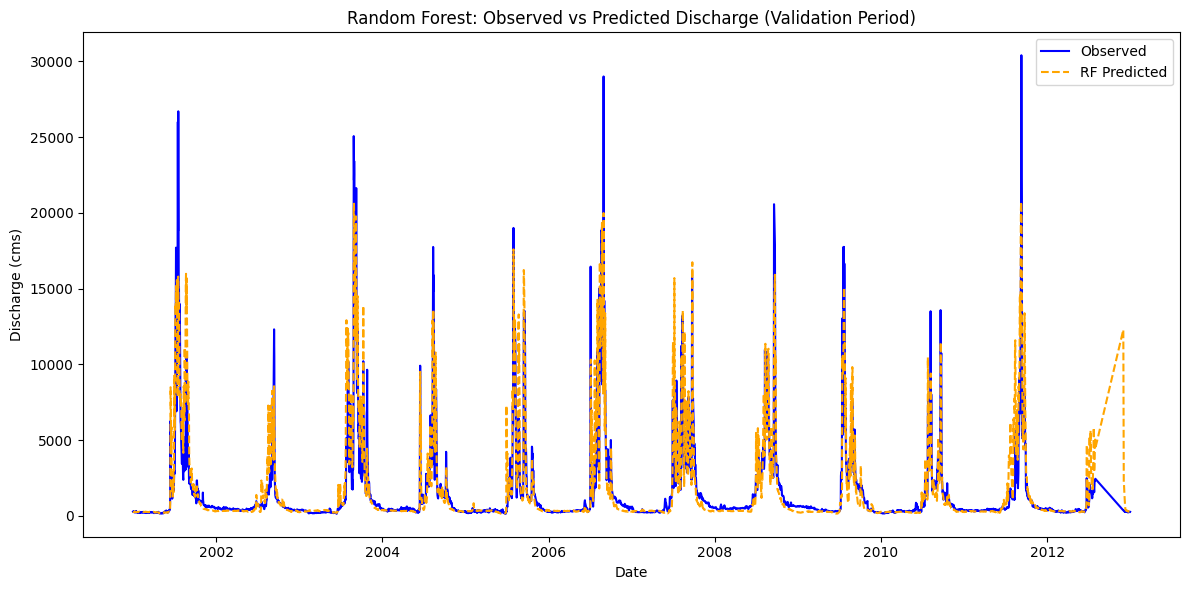

In [13]:
# -------------------------------
# Step 1: Import libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# Define PBIAS calculation function
def pbias(obs, sim):
    """Calculate Percent Bias"""
    return 100 * (np.sum(sim - obs) / np.sum(obs))

# -------------------------------
# Step 2: Load datasets and rename columns
# -------------------------------
# [Keep all dataset loading and renaming code from original]
# ... [original dataset loading code] ...

# -------------------------------
# Step 3: Merge all datasets
# -------------------------------
# [Keep original merging code]
# ... [original merging code] ...

# -------------------------------
# Step 4: Drop missing values
# -------------------------------
# [Keep original data cleaning code]
# ... [original data cleaning code] ...

# -------------------------------
# Step 5: Define features and target
# -------------------------------
# [Keep original feature/target definition]
# ... [original feature/target code] ...

# -------------------------------
# Step 6: Scale features and target
# -------------------------------
# [Keep original scaling code]
# ... [original scaling code] ...

# -------------------------------
# Step 7: Create sequences
# -------------------------------
# [Keep original sequence creation code]
# ... [original sequence code] ...

# -------------------------------
# Step 8: Train-Test Split
# -------------------------------
# [Keep original split code]
# ... [original split code] ...

# -------------------------------
# Step 13: Random Forest Model with PBIAS
# -------------------------------
# Flatten the sequence data
X_train_flat = X_train_seq.reshape(X_train_seq.shape[0], -1)
X_val_flat = X_val_seq.reshape(X_val_seq.shape[0], -1)

# Train model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train_seq.ravel())

# Generate predictions
y_train_pred = rf_model.predict(X_train_flat)
y_val_pred = rf_model.predict(X_val_flat)

# Inverse scaling
y_train_actual = target_scaler.inverse_transform(y_train_seq.reshape(-1, 1))
y_train_pred = target_scaler.inverse_transform(y_train_pred.reshape(-1, 1))
y_val_actual = target_scaler.inverse_transform(y_val_seq.reshape(-1, 1))
y_val_pred = target_scaler.inverse_transform(y_val_pred.reshape(-1, 1))

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
train_nse = 1 - (np.sum((y_train_actual - y_train_pred)**2) / 
                np.sum((y_train_actual - np.mean(y_train_actual))**2))
train_r2 = r2_score(y_train_actual, y_train_pred)
train_pbias = pbias(y_train_actual, y_train_pred)

val_rmse = np.sqrt(mean_squared_error(y_val_actual, y_val_pred))
val_nse = 1 - (np.sum((y_val_actual - y_val_pred)**2) / 
              np.sum((y_val_actual - np.mean(y_val_actual))**2))
val_r2 = r2_score(y_val_actual, y_val_pred)
val_pbias = pbias(y_val_actual, y_val_pred)

# Print results
print("\nRandom Forest Performance Metrics")
print("+----------------------+-----------+-----------+------------+-----------+")
print("| Period               | NSE       | R²        | RMSE (cms) | PBIAS (%) |")
print("+----------------------+-----------+-----------+------------+-----------+")
print(f"| Calibration (2000-) | {train_nse:.4f}  | {train_r2:.4f}  | {train_rmse:.2f}     | {train_pbias:.2f}    |")
print(f"| Validation (2001-12) | {val_nse:.4f}  | {val_r2:.4f}  | {val_rmse:.2f}     | {val_pbias:.2f}    |")
print("+----------------------+-----------+-----------+------------+-----------+")

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(dates[val_idx], y_val_actual, label='Observed', color='blue')
plt.plot(dates[val_idx], y_val_pred, label='RF Predicted', color='orange', linestyle='--')
plt.title('Random Forest: Observed vs Predicted Discharge (Validation Period)')
plt.xlabel('Date')
plt.ylabel('Discharge (cms)')
plt.legend()
plt.tight_layout()
plt.show()